In [1]:
%pip install -r requirements.txt 

Note: you may need to restart the kernel to use updated packages.


In [2]:
st_petersburg_incart_12lead_arrhythmia_database_path = r'data/china-12lead-ecg-challenge-database'
ptbxl_electrocardiography_database_path = r'data/ptbxl_electrocardiography_database'
ptb_diagnostic_ecg_database_path = r'data/ptb_diagnostic_ecg_database'
china_physiological_signal_challenge_in_2018_path = r'data/china_physiological_signal_challenge_2018'
china_12lead_ecg_challenge_database_path = r'data/china_12lead_ecg_challenge_database'
physionet_snomed_mappings_path = r'data/physionet_snomed_mappings'
physionet_challenge_models_path = r'datas/physionet_challenge_models'
georgia_12lead_ecg_challenge_database_path = r'data/georgia_12lead_ecg_challenge_database'
physionet_challenge_utility_script_path = r'utils/physionet_challenge_utility_script_patched_v2.py'

In [3]:
import sys
import os

# Add the directory to sys.path
sys.path.append(os.path.dirname(physionet_challenge_utility_script_path))

# Optionally set the working directory (only if needed)
os.chdir(r"../cvd-early-detection-ecg-uhull")

# Check the current working directory
print("Current directory:", os.getcwd())

FileNotFoundError: [WinError 2] The system cannot find the file specified: '../cvd-early-detection-ecg-uhull'

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ecg_plot

import tensorflow as tf
import keras

from scipy import optimize
from matplotlib.pyplot import figure

from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences

In [8]:
%load_ext autoreload
%autoreload
%reload_ext autoreload

import physionet_challenge_utility_script_patched_v2 as pc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


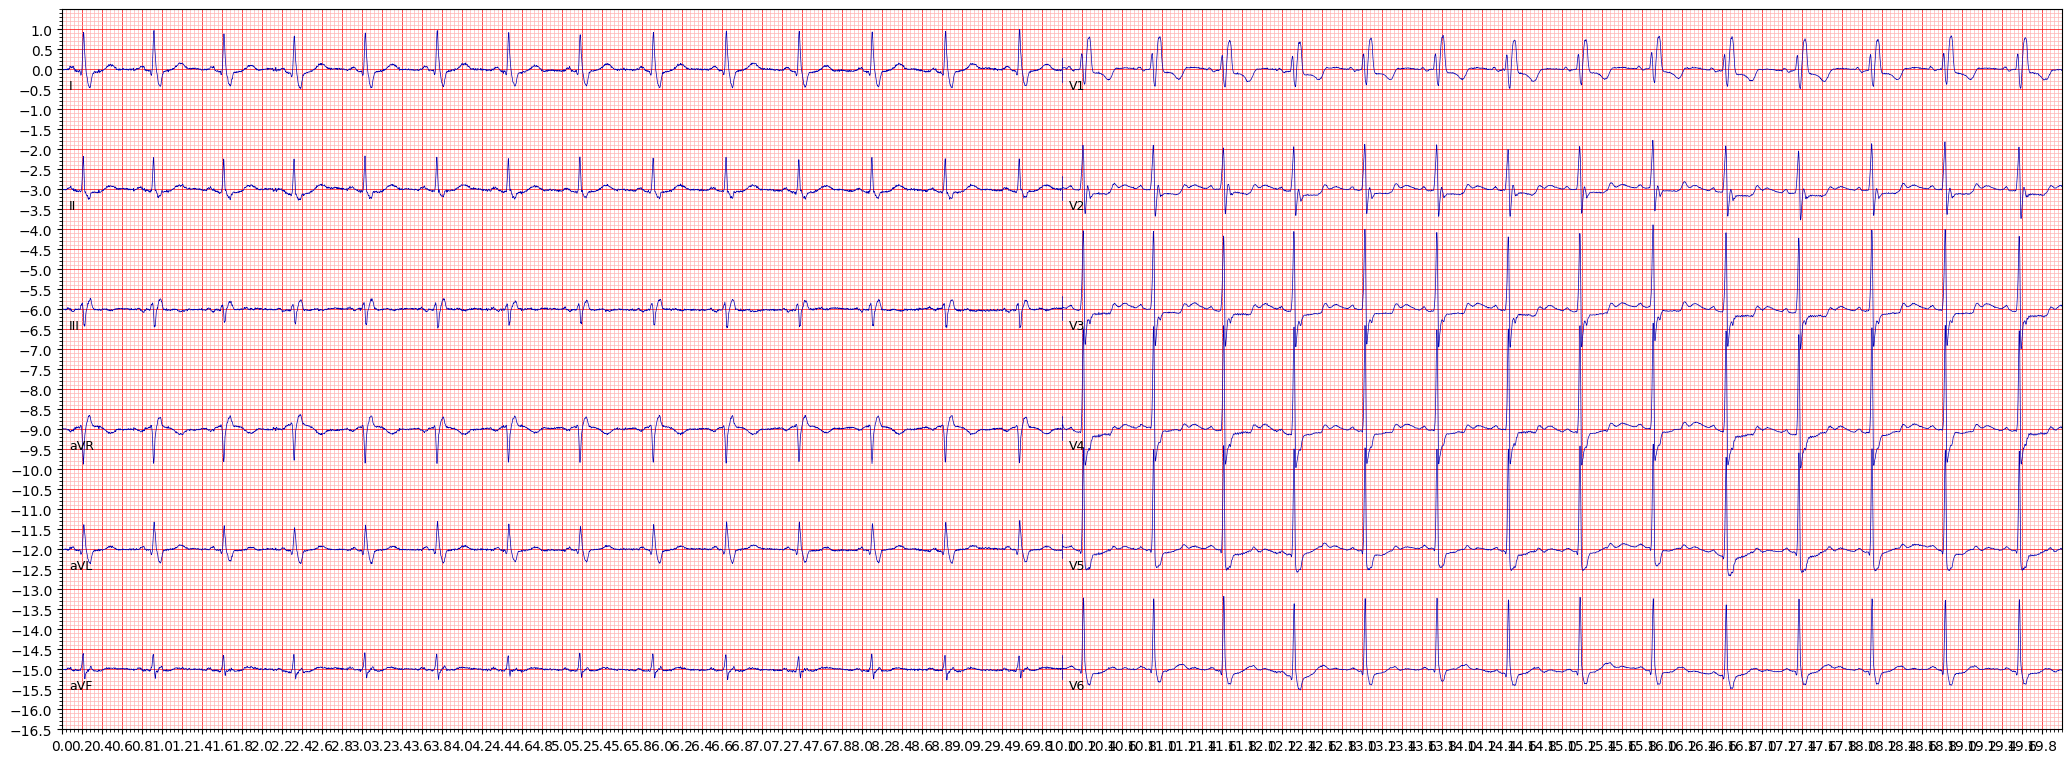

In [ ]:
def plot_ecg(path):
    ecg_data = pc.load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()

plot_ecg('data/china-12lead-ecg-challenge-database/Training_2/Q0948.mat') 

In [15]:
ecg_data = pc.load_challenge_data("data/china-12lead-ecg-challenge-database/Training_2/Q0002.mat")
ecg_data[0].shape

(12, 7500)

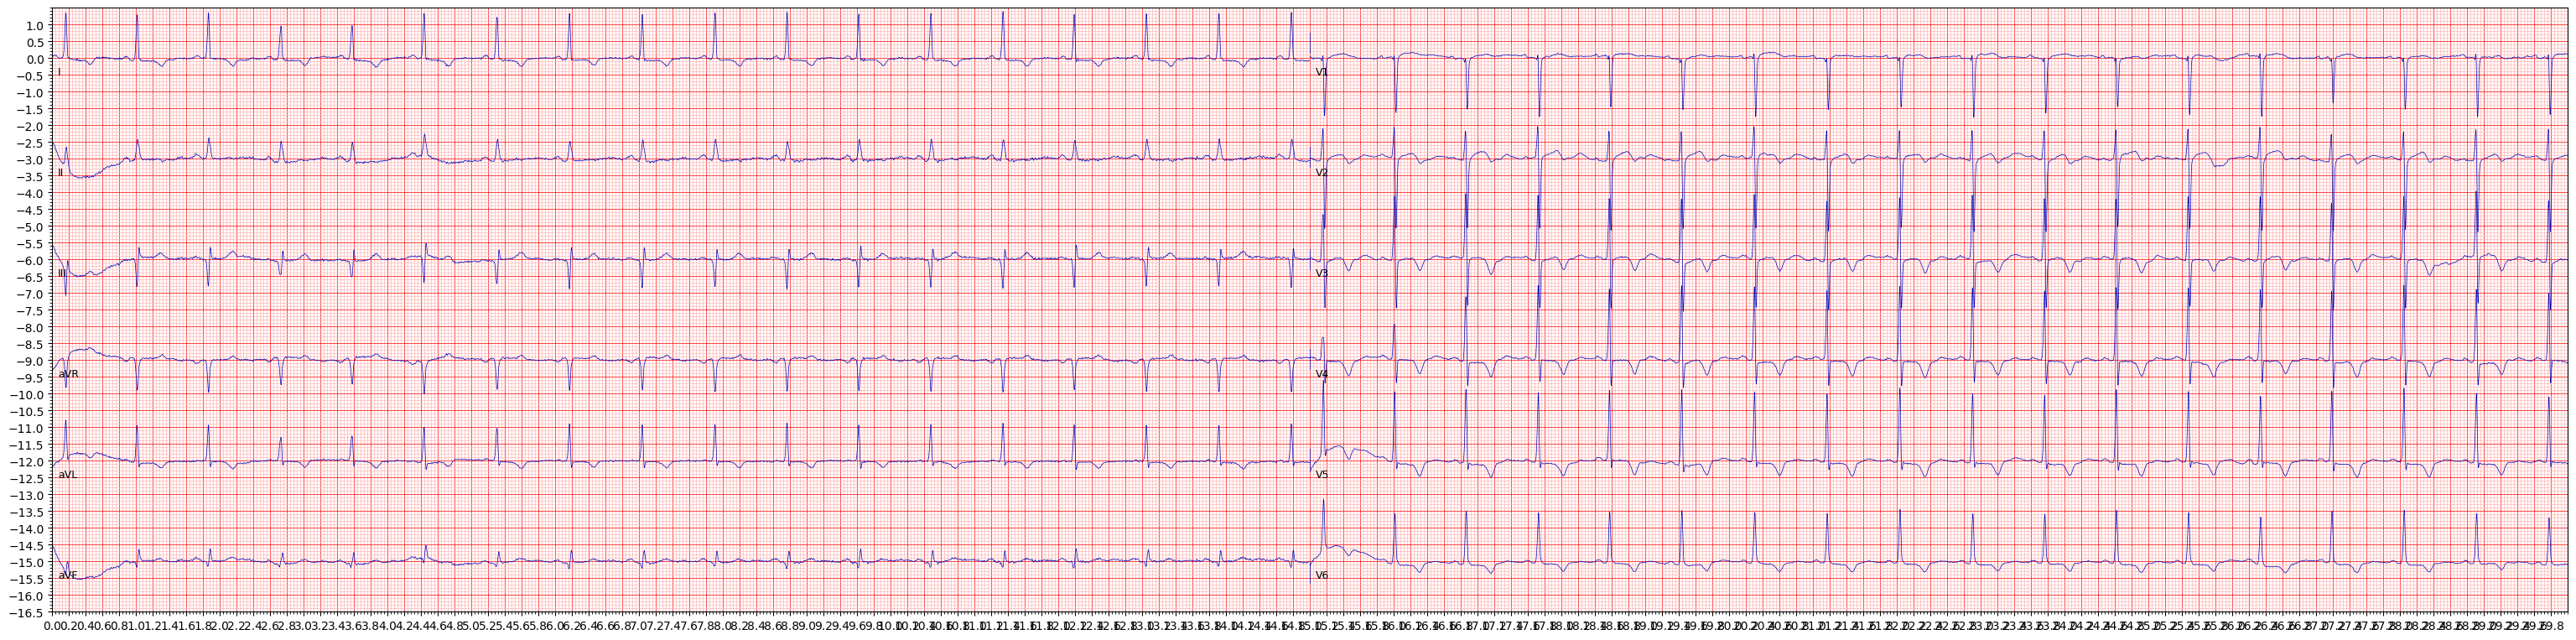

In [16]:
plot_ecg("data/china-12lead-ecg-challenge-database/Training_2/Q0002.mat")

In [17]:
gender, age, labels, ecg_filenames = pc.import_key_data("data")
ecg_filenames = np.asarray(ecg_filenames)

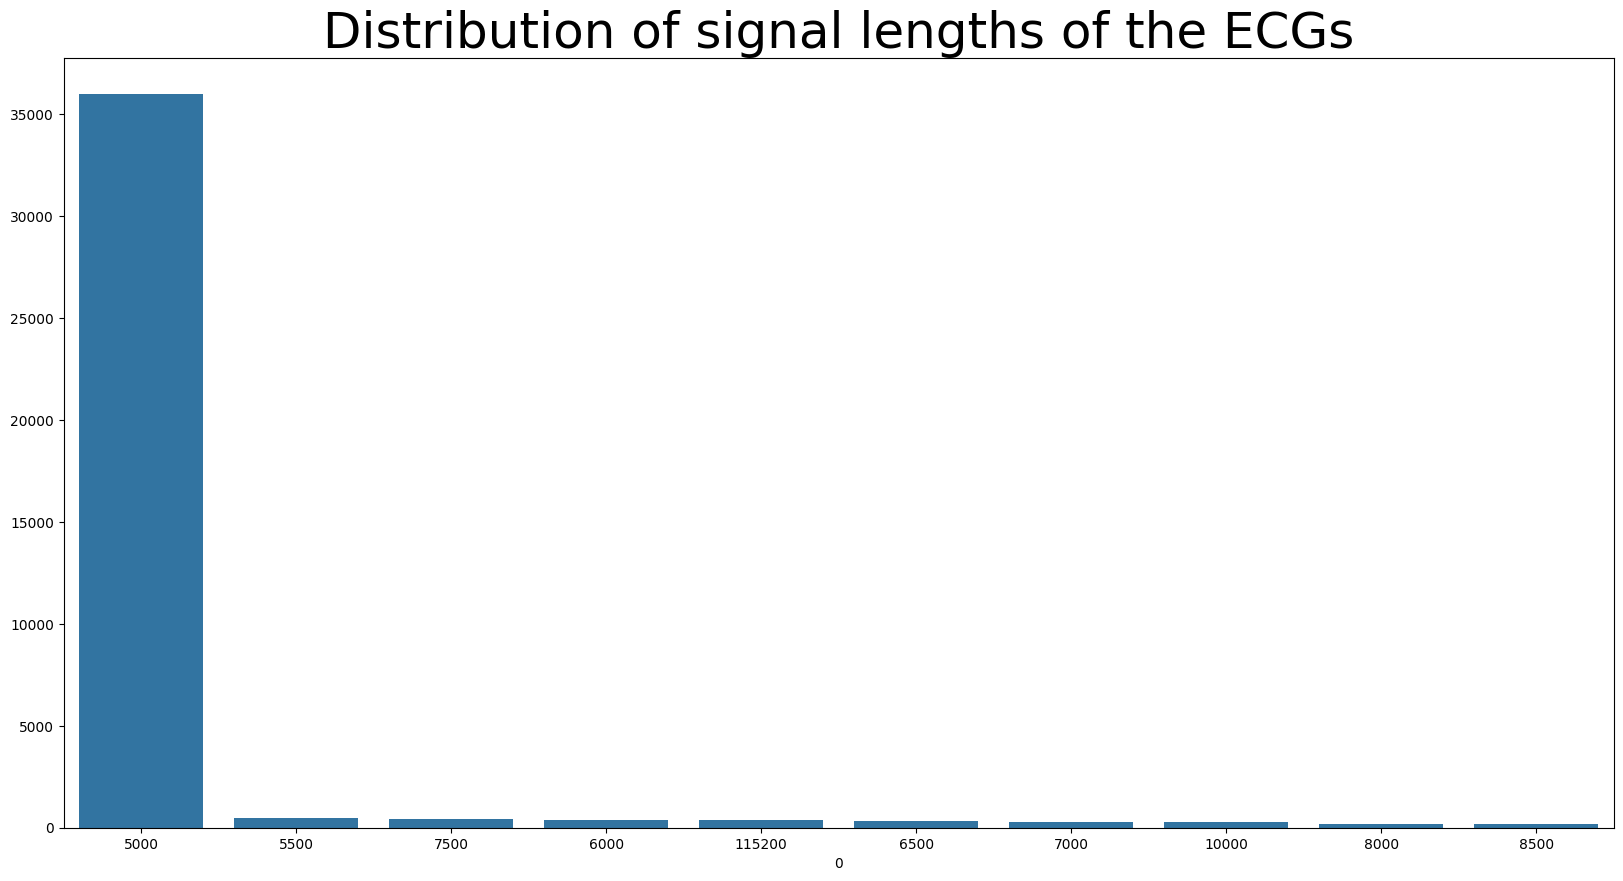

In [18]:
pc.get_signal_lengths("data", "Distribution of signal lengths of the ECGs")

In [19]:
age, gender = pc.import_gender_and_age(age, gender)

gender data shape: 43101
age data shape: 43101


In [20]:
SNOMED_scored = pd.read_csv("data/physionet-snomed-mappings/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored = pd.read_csv("data/physionet-snomed-mappings/SNOMED_mappings_unscored.csv", sep=";")

df_labels = pc.make_undefined_class(labels,SNOMED_unscored)

In [21]:
y, snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 27


In [22]:
snomed_abbr = []

for j in range(len(snomed_classes)):
    for i in range(len(SNOMED_scored.iloc[:,1])):
        if (str(SNOMED_scored.iloc[:,1][i]) == snomed_classes[j]):
            snomed_abbr.append(SNOMED_scored.iloc[:,2][i])
            
snomed_abbr = np.asarray(snomed_abbr)

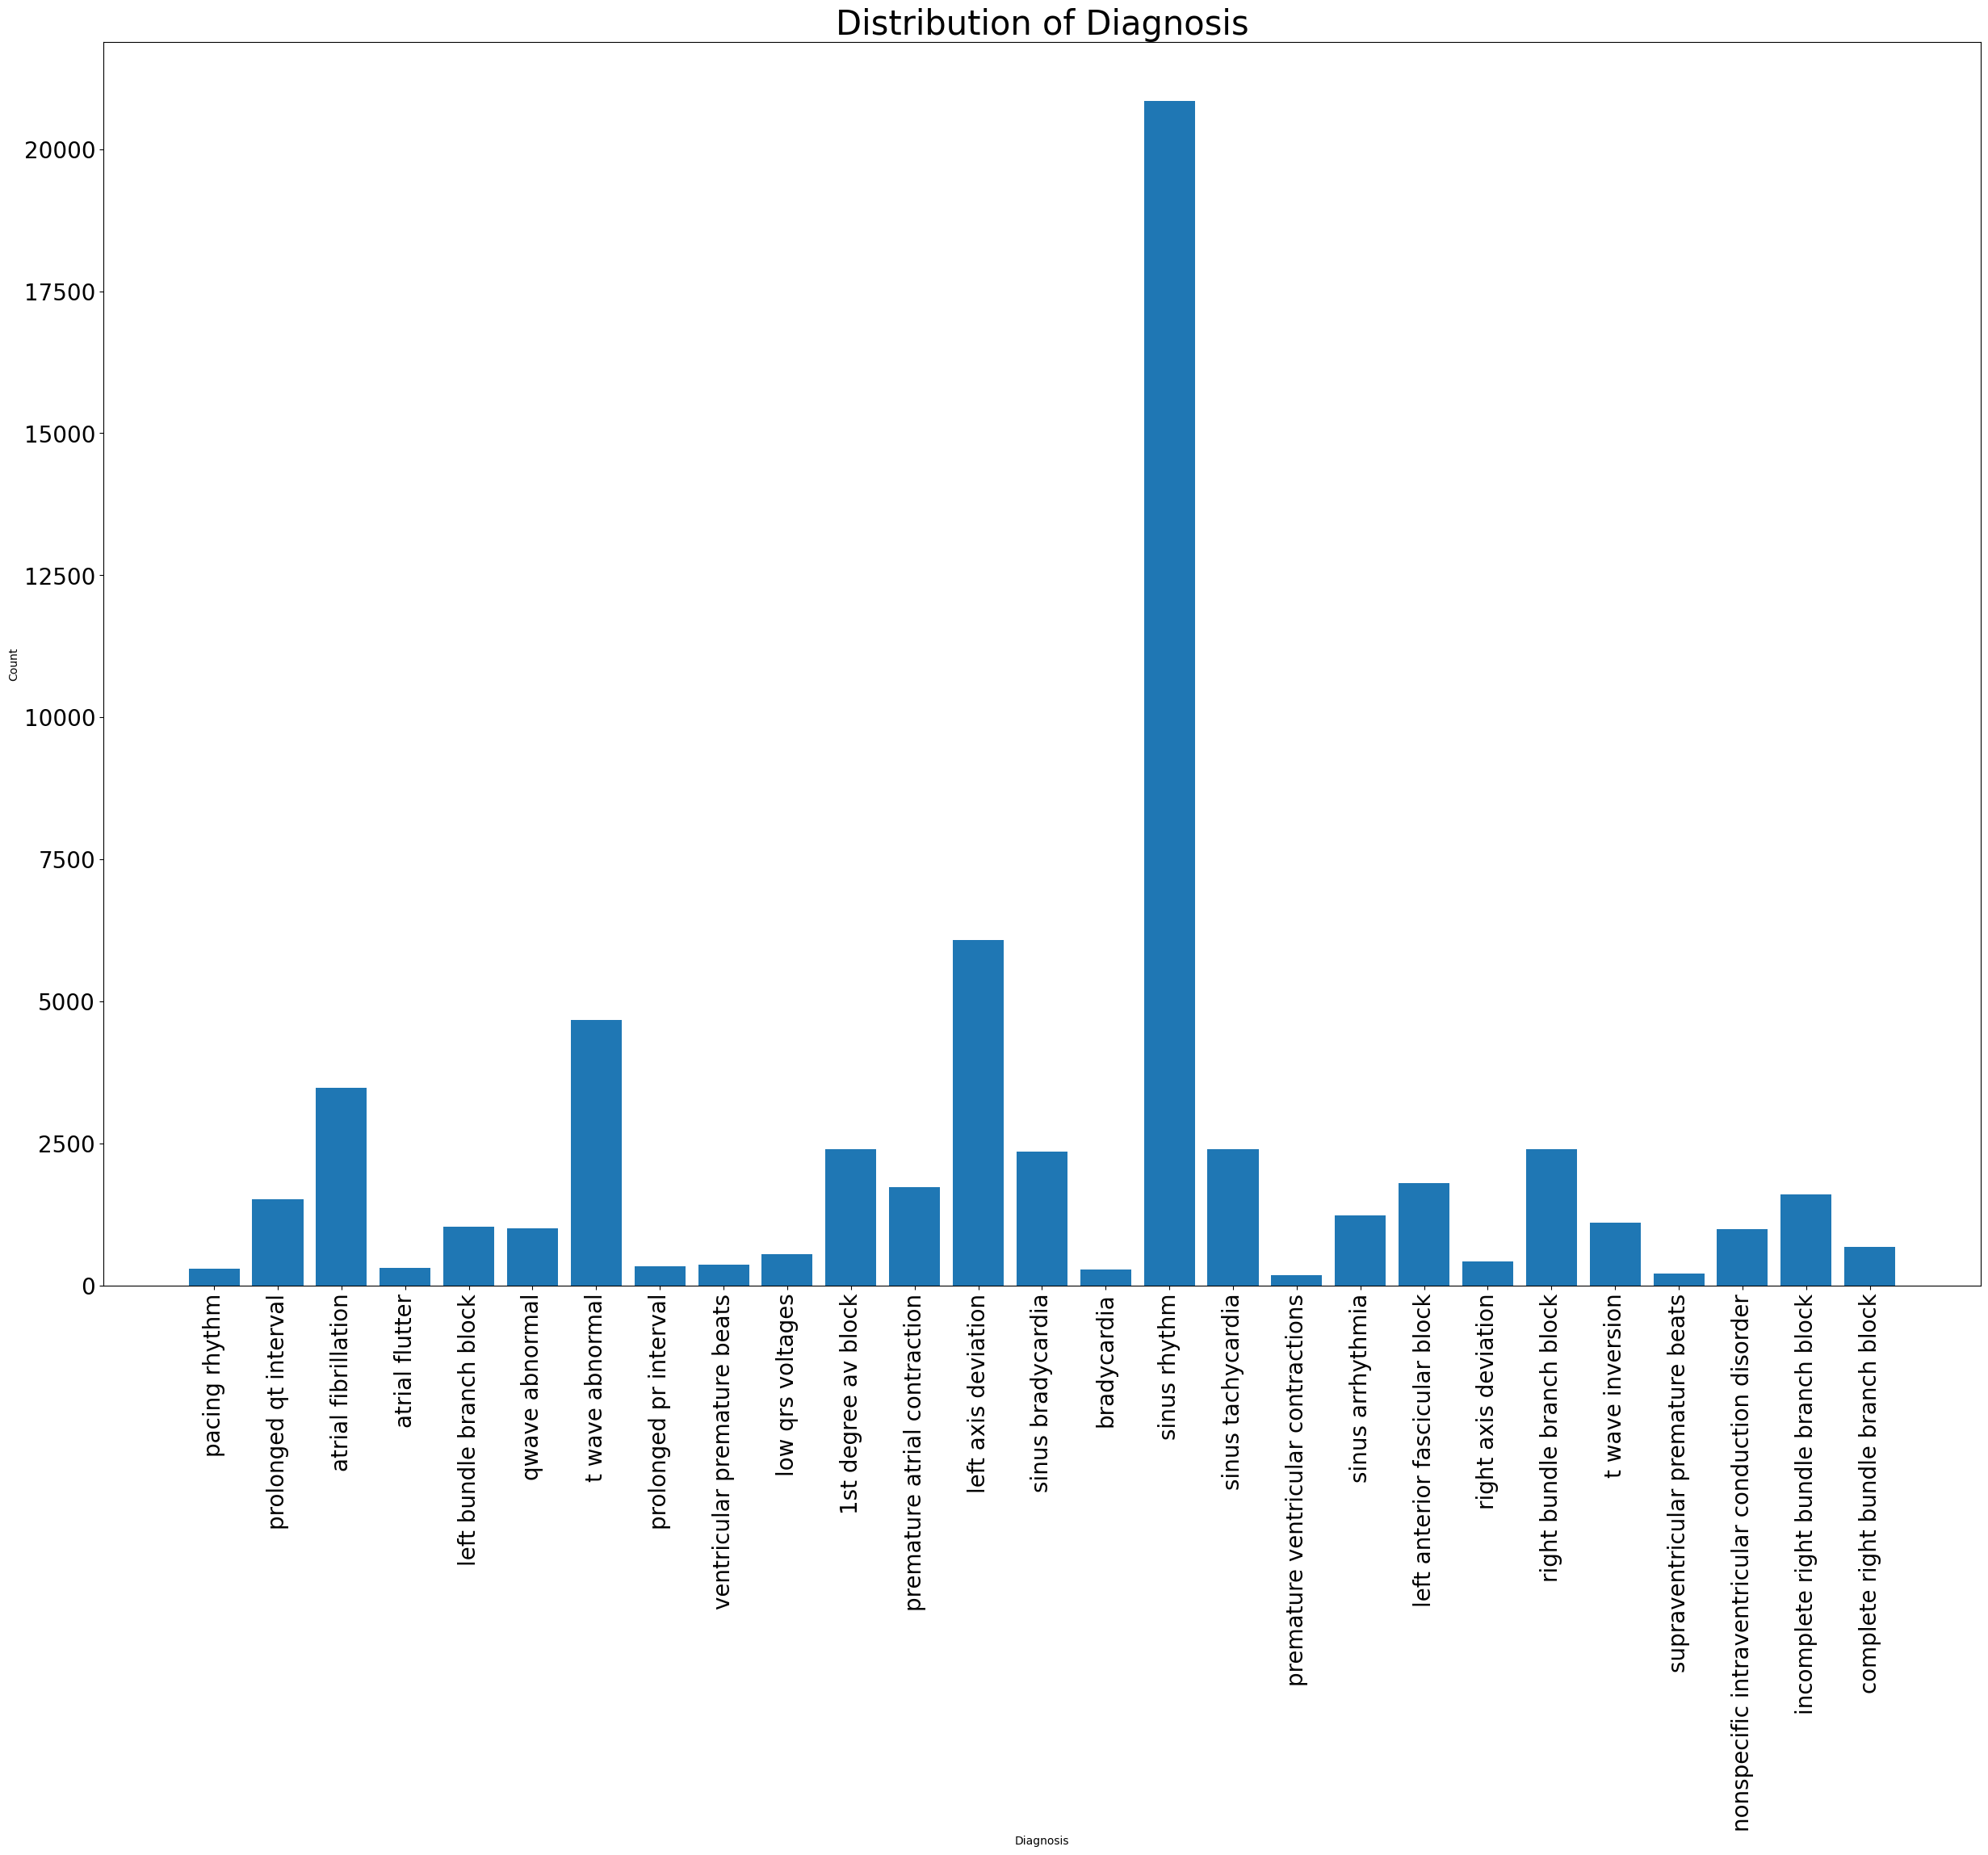

In [23]:
pc.plot_classes(snomed_classes, SNOMED_scored,y)

In [24]:
y_all_comb = pc.get_labels_for_all_combinations(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_all_comb))))

Total number of unique combinations of diagnosis: 1414


In [25]:
folds = pc.split_data(labels, y_all_comb)

Training split: 38790
Validation split: 4311


C:\Users\nares\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


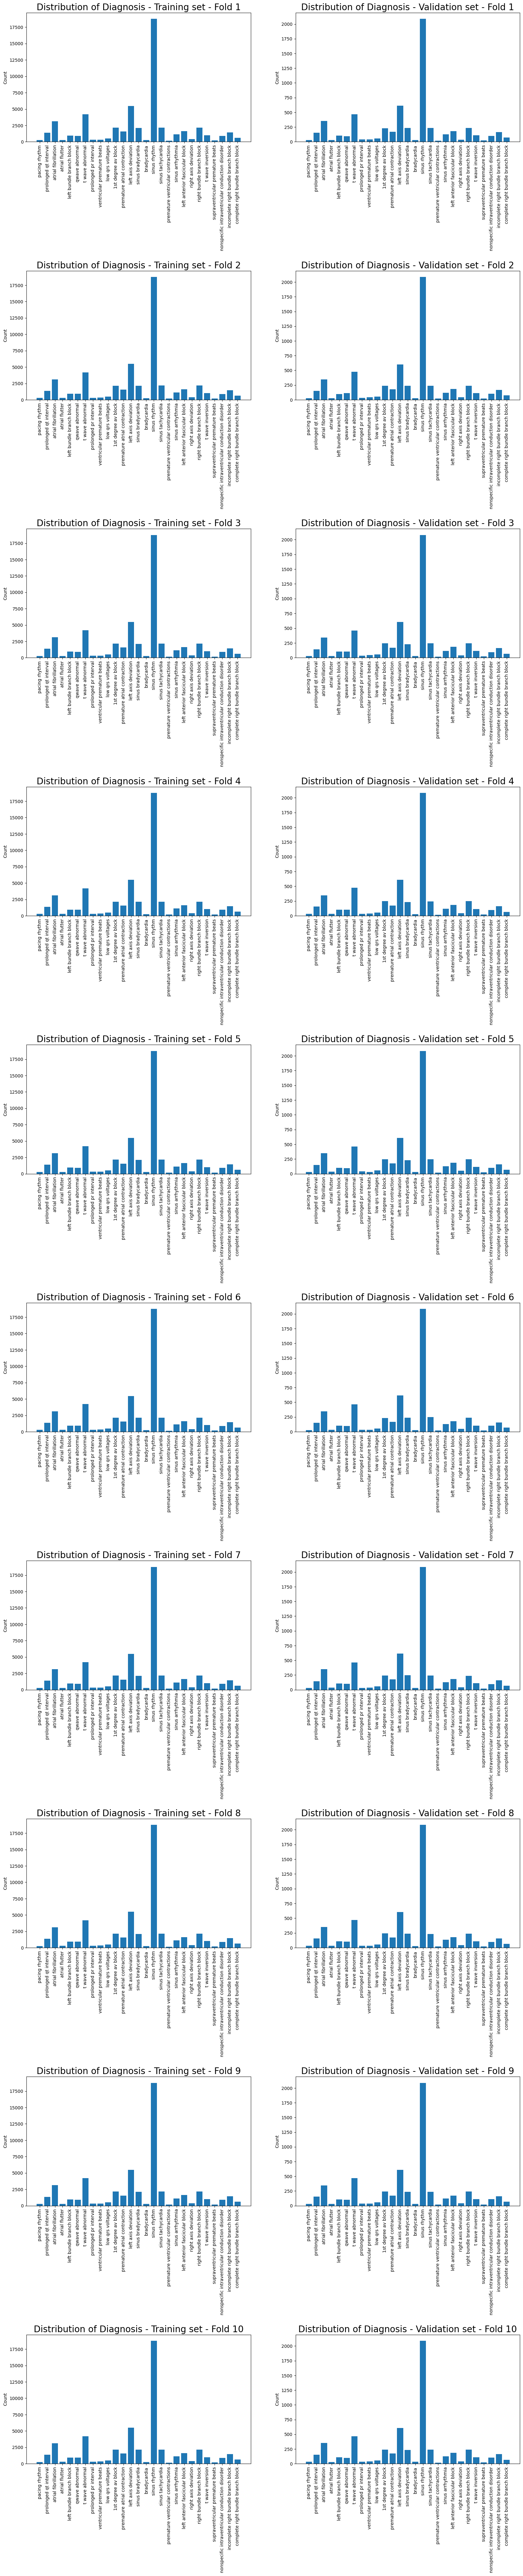

In [26]:
pc.plot_all_folds(folds,y,snomed_classes)

In [27]:
order_array = folds[0][0]

In [28]:
def shuffle_batch_generator_demo(batch_size, gen_x,gen_y, gen_z): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    batch_demo_data = np.zeros((batch_size,2))
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            batch_demo_data[i] = next(gen_z)

        X_combined = [batch_features, batch_demo_data]
        yield X_combined, batch_labels

def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled

def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

def generate_z_shuffle(age_train, gender_train):
    while True:
        for i in order_array:
            gen_age = age_train[i]
            gen_gender = gender_train[i]
            z_train = [gen_age , gen_gender]
            yield z_train

In [29]:
new_weights = pc.calculating_class_weights(y)

In [30]:
keys = np.arange(0,27,1)
weight_dictionary = dict(zip(keys, new_weights.T[1]))
weight_dictionary

{0: 72.0752508361204,
 1: 14.243555849306015,
 2: 6.201582733812949,
 3: 68.63216560509554,
 4: 20.701729106628243,
 5: 21.273938795656466,
 6: 4.611705542478066,
 7: 63.383823529411764,
 8: 59.04246575342466,
 9: 38.759892086330936,
 10: 9.00187969924812,
 11: 12.464141122035858,
 12: 3.5409957279000985,
 13: 9.13543874523103,
 14: 74.828125,
 15: 1.0337954523649622,
 16: 8.971898417985013,
 17: 114.63031914893617,
 18: 17.379435483870967,
 19: 11.932724252491694,
 20: 50.469555035128806,
 21: 8.971898417985013,
 22: 19.379946043165468,
 23: 100.23488372093023,
 24: 21.615346038114343,
 25: 13.37709497206704,
 26: 31.552708638360176}

In [31]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=2)

In [32]:

def thr_chall_metrics(thr, label, output_prob):
    return -pc.compute_challenge_metric_for_opt(label, np.array(output_prob>thr))

In [33]:
model = pc.residual_network_1d()

In [34]:
model.load_weights("data/physionet-challenge-models/resnet_model.h5")

In [35]:
# batchsize = 30
# model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=100, steps_per_epoch=(len(order_array)/batchsize), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), validation_freq=1, class_weight=weight_dictionary, callbacks=[reduce_lr,early_stop])

In [36]:
y_pred = model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

135/135 [==============================] - 115s 850ms/step


In [37]:
init_thresholds = np.arange(0,1,0.05)

In [38]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.1516625863156977
0.3257728585224567
0.34907885319229215
0.28868950738443655
0.181260365067383
0.07488523992867367
-0.030592151530913974
-0.13422631975369734
-0.2242114341113018
-0.3122581976641526
-0.3953465808086114
-0.47448587178946944
-0.5439621181557601
-0.6015332151710997
-0.6651141368699174
-0.7092221508645785
-0.7470735743049693
-0.7760926050516812
-0.8006819928304572
-0.8173020165059404


In [39]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.380630
         Iterations: 302
         Function evaluations: 579


In [40]:
print(pc.compute_challenge_metric_for_opt(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],(y_pred>new_best_thr)*1))

0.38063028434382484


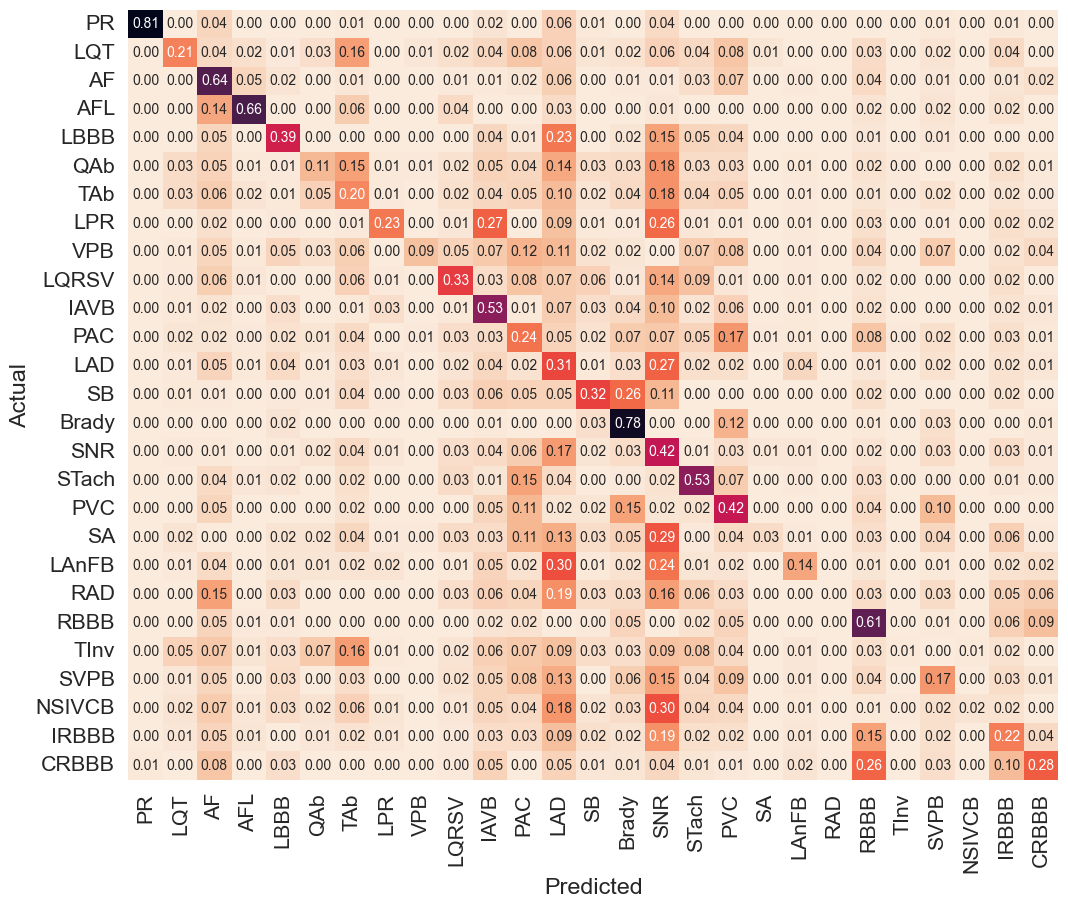

In [41]:
pc.plot_normalized_conf_matrix(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes, snomed_abbr)
plt.savefig("confusion_matrix_resnet.png", dpi=100)

In [42]:
test_aa = pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0]
print(test_aa.shape)

(4311, 5000, 12)


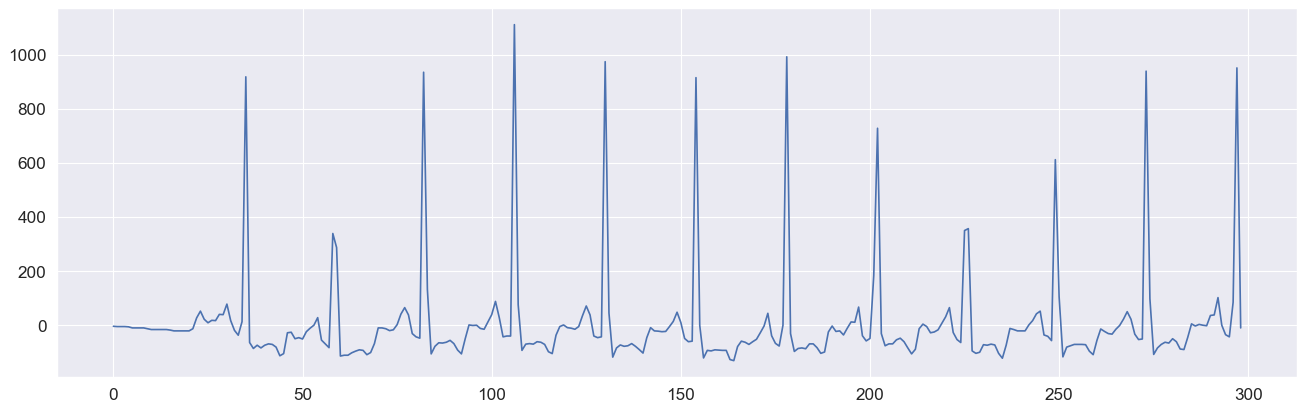

In [43]:
figure(figsize=(20, 6), dpi=80)
plt.plot(test_aa[0,1:300,1])

In [44]:
y_pred.shape

(4311, 27)

In [45]:
test_aa[:2,:,:].shape

(2, 5000, 12)

In [52]:
x = test_aa[:2,:,:]
y = y_pred[:2,:]

In [58]:
!git clone https://github.com/OverLordGoldDragon/see-rnn.git

Cloning into 'see-rnn'...


In [59]:
import sys
sys.path.insert(1, '')

In [61]:
from see_rnn.inspect_gen import get_gradients, get_outputs, features_0D, features_1D, features_2D

ModuleNotFoundError: No module named 'tensorflow.python.keras.mixed_precision.experimental'

In [ ]:
grads_all  = see_rnn.get_gradients(model, 1, x, y)  # return_sequences=True,  layer index 1
grads_last = see_rnn.get_gradients(model, 2, x, y)  # return_sequences=False, layer index 2

outs  = get_outputs(model, 1, x) 

AttributeError: 'Adam' object has no attribute '_HAS_AGGREGATE_GRAD'

In [ ]:
features_1D(grads_all, n_rows=4)
features_0D(grads_last[1,0:160,:2])
features_2D(outs[0])

In [ ]:
features_0D(grads_last[1,0:160,:2])

In [ ]:
# https://stackoverflow.com/questions/58356868/how-visualize-attention-lstm-using-keras-self-attention-package
def show_features_1D_nv(model=None, layer_name=None, input_data=None,
                            prefetched_outputs=None, max_timesteps=100,
                            max_col_subplots=10, equate_axes=False,
                            show_y_zero=True, channel_axis=-1,
                            scale_width=1, scale_height=1, dpi=76):
    if prefetched_outputs is None:
        layer_outputs = get_layer_outputs(model, layer_name, input_data, 1)[0]
    else:
        layer_outputs = prefetched_outputs
    n_features    = layer_outputs.shape[channel_axis]

    for _int in range(1, max_col_subplots+1):
          if (n_features/_int).is_integer():
                n_cols = int(n_features/_int)
    n_rows = int(n_features/n_cols)

    fig, axes = plt.subplots(n_rows,n_cols,sharey=equate_axes,dpi=dpi)
    fig.set_size_inches(24*scale_width,16*scale_height)

    subplot_idx = 0
    for row_idx in range(axes.shape[0]):
        for col_idx in range(axes.shape[1]): 
            subplot_idx += 1
            feature_output = layer_outputs[:,subplot_idx-1]
            feature_output = feature_output[:max_timesteps]
            ax = axes[row_idx,col_idx]

            if show_y_zero:
                ax.axhline(0,color='red')
            ax.plot(feature_output)

            ax.axis(xmin=0,xmax=len(feature_output))
            ax.axis('off')

            ax.annotate(str(subplot_idx),xy=(0,.99),xycoords='axes fraction',
                        weight='bold',fontsize=14,color='g')
    if equate_axes:
        y_new = []
        for row_axis in axes:
            y_new += [np.max(np.abs([col_axis.get_ylim() for 
                                        col_axis in row_axis]))]
        y_new = np.max(y_new)
        for row_axis in axes:
            [col_axis.set_ylim(-y_new,y_new) for col_axis in row_axis]
    plt.show()

show_features_1D_nv(grads_all, prefetched_outputs = outs)

In [ ]:
print(grads_all.shape)
end_time = 1000
figure(figsize=(25, 6), dpi=80)
# plt.plot(test_aa[0,1:1000,1]/1000)
plt.plot(pd.DataFrame(outs[0]).max(axis= 1).values[:end_time]/2000,'r')
plt.plot(pd.DataFrame(outs[1]).max(axis= 1).values[:end_time]/2000,'c')
plt.plot(test_aa[0,:end_time,1]/1000)
plt.show()

In [ ]:
grads_all.shape

In [ ]:
end_time = int(5000/28)
thresh = 0.2
x_range = range(end_time)
# gradient_1 = pd.DataFrame(grads_all[0,:,:]).abs().max(axis= 1).values[:end_time]*10**13
gradient_1 = pd.DataFrame(grads_last[0,:,:]).abs().max(axis= 1).values[:end_time]*10**10
gradient_12 = []
for ii in range(end_time):
    if gradient_1[ii] >= thresh:
        gradient_12.append(test_aa[0,ii,1])
    else:
        gradient_12.append(0)

figure(figsize=(25, 6), dpi=80)
# plt.plot(test_aa[0,1:1000,1]/1000)
# plt.plot(gradient_12,'r',linewidth=5.0)
# plt.plot(np.array(np.where(gradient_1 >=0.2)).reshape(-1,1), gradient_1[np.where(gradient_1 >= 0.2)],'r',linewidth=5.0)
# plt.scatter(np.array(np.where(gradient_1 >=thresh)).reshape(-1,1), gradient_1[np.where(gradient_1 >= thresh)], c='r')
plt.scatter(np.array(np.where(gradient_1 >=thresh)).reshape(-1,1), pd.DataFrame(gradient_12).iloc[np.where(gradient_1 >= thresh)], c='r')
plt.plot(test_aa[0,:end_time,1],linewidth=3)
plt.show()

In [ ]:
pd.DataFrame(grads_all[0,:,:]).abs().max(axis= 1).values[:end_time]*10**13

In [ ]:
ecg_data = pc.load_challenge_data(ecg_filenames[0])
ecg_data2 = np.array(ecg_data)

end_time = 5000
thresh = 1.2
x_range = range(end_time)
gradient_1 = pd.DataFrame(grads_all[0,:,:]).abs().max(axis= 1).values[:end_time]*10**13
gradient_12 = []
for ii in range(end_time):
    if gradient_1[ii] >= thresh:
        gradient_12.append(ecg_data2[0][0,ii]/1000)
    else:
        gradient_12.append(0)

fig, ax = plt.subplots(figsize=(25, 6), dpi=200)

fig.suptitle(snomed_classes[np.argmax(y_pred[0])])

ax.scatter(np.array(np.where(gradient_1 >=thresh)).reshape(-1,1), pd.DataFrame(gradient_12).iloc[np.where(gradient_1 >= thresh)], c='r', s = 200, alpha= 0.7)
step = 1.0/500
# plt.scatter(np.arange(0, len(np.array(np.where(gradient_1 >=thresh)).reshape(-1,1))*step, step), pd.DataFrame(gradient_12).iloc[np.where(gradient_1 >= thresh)], c='r')
plt.plot(ecg_data2[0][0, :end_time]/1000,linewidth=3)

# ax.plot(np.arange(0, len(ecg_data2[0][0, :end_time])*step, step), ecg_data2[0][0, :end_time],  linewidth=2.0, color='b')
plt.show()

In [ ]:
print(ecg_data2[0].shape)
ecg_plot.plot(ecg_data2[0]/1000, sample_rate=500, title='')
ecg_plot.show()